# CompGCN Graph Model Training - 950 - 50

In [1]:
#!pip install pykeen
#!pip install seaborn

In [145]:
import numpy as np
import pandas as pd
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
import joblib
from sklearn.manifold import TSNE
from itertools import cycle
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.special import softmax
from tqdm.notebook import tqdm
from datetime import datetime

In [146]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    # output expected:
    # tensor([1.], device='mps:0')

else:
    print ("MPS device not found.")



MPS device not found.


In [147]:
#abc = ["a", "b", "c", "d", "e", "f", "g"]
#print(abc[0:3])
#print(abc[3:])

In [148]:
size_train = 950
y = joblib.load("../Data Generation/outcomes_950_50.joblib")
y_train = y[:size_train]
y_test = y[size_train:]
size_test = len(y_test)

In [149]:
pd.DataFrame(y).value_counts()

0
0    456
1    429
2    115
Name: count, dtype: int64

In [150]:
pd.DataFrame(y_train).value_counts()

0
0    433
1    406
2    111
Name: count, dtype: int64

In [151]:
pd.DataFrame(y_test).value_counts()

0
0    23
1    23
2     4
Name: count, dtype: int64

In [152]:
preproc_df = pd.read_csv("../Data Generation/sphn_pc_transductive_950_50.nt", sep=" ")
preproc_df.drop(columns=preproc_df.columns[-1], axis=1, inplace=True)
preproc_df.to_csv("../Data Generation/sphn_pc_transductive_950_50.tsv", sep="\t", index=False)
preproc_df

,<http://nvasc.org/synth_patient_379>,<http://nvasc.org/hasDiagnosis>,<http://nvasc.org/aaff6742-dad3-4eac-84cf-9e709a71f602>
0,<http://nvasc.org/b8877b09-f3b1-480b-8192-1fed...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Diagnosis>
1,<http://nvasc.org/b69ec15b-1e3d-4b3d-a0da-628b...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Diagnosis>
2,<http://nvasc.org/aa9c30ec-6791-4d31-bb91-4c0c...,<http://sphn.org/hasCode>,<http://nvasc.org/code_o2_clinic_0.0>
3,<http://nvasc.org/aa179eea-24c0-4f87-8229-1bea...,<http://www.w3.org/2000/01/rdf-schema#label>,iot^^<http://www.w3.org/2001/XMLSchema#string>
4,<http://nvasc.org/synth_patient_30>,<http://nvasc.org/hasDiagnosis>,<http://nvasc.org/d03a97df-b14d-4e53-8791-ec89...
...,...,...,...
111879,<http://nvasc.org/6cbe9495-cfb1-4cb9-8007-1ef5...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Diagnosis>
111880,<http://nvasc.org/gender_519>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/AdministrativeGender>
111881,<http://nvasc.org/fbdb1974-aae8-4fcb-8534-20f8...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Diagnosis>
111882,_:ne27079afda714aa4bfdd6b0bfd435694b1,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Quantity>


In [153]:
# tf = TriplesFactory.from_path("syn_data_graph.xml")
tf = TriplesFactory.from_path("../Data Generation/sphn_pc_transductive_950_50.tsv", create_inverse_triples=True)

In [154]:
n_runs = 1
epochs = 5

y_pred = np.zeros((n_runs, len(y_test)))
#y_pred = np.zeros((n_runs, len(y_train)))
y_probs = np.zeros((n_runs, len(y_test), 3))
#y_probs = np.zeros((n_runs, len(y_train), 3))
log_loss = np.zeros((n_runs, epochs))
hits = np.zeros((n_runs, 4))

In [155]:
print("start: " + str(datetime.now().isoformat()))
for run in range(n_runs):
    model_name = 'CompGCN'
    #model_name = 'RGCN'
    dataset = 'RIA'
    embedding_dim = 80

    result = pipeline(
        model=model_name,       
        training=tf,
        testing=tf,
        model_kwargs=dict(
            embedding_dim=embedding_dim,      
            loss="softplus",
            #num_layers=2,
            #interaction="TransE",
            #interaction_kwargs=dict(
            #    p=2
            #)
        ),  
        optimizer_kwargs=dict(
            lr=0.001,
            weight_decay=1e-4,
        ),  
        training_kwargs=dict(
            num_epochs=epochs, 
            use_tqdm_batch=False,
        ),  
        training_loop='sLCWA',
        negative_sampler='basic',
        device='gpu',
        use_tqdm=True,
        
    )
print("end: " + str(datetime.now().isoformat()))

INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.


start: 2024-10-17T17:21:02.912772


Training epochs on cuda:0:   0%|          | 0/5 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/874 (0.11%) batches).
Training epochs on cuda:0: 100%|██████████| 5/5 [04:34<00:00, 54.86s/epoch, loss=0.13, prev_loss=0.163] 
Evaluating on cuda:0: 100%|██████████| 112k/112k [00:15<00:00, 7.44ktriple/s] 
INFO:pykeen.evaluation.evaluator:Evaluation took 15.73s seconds


end: 2024-10-17T17:25:53.341513


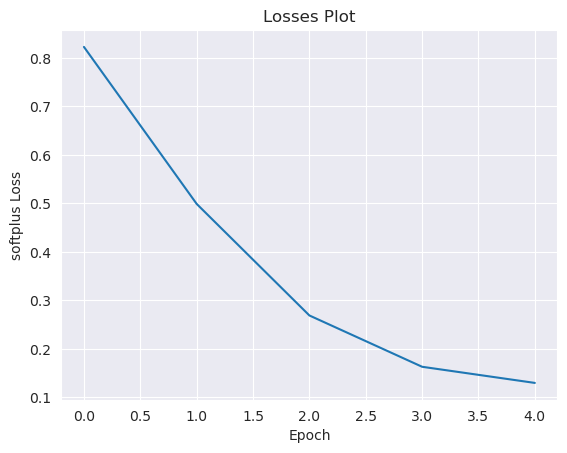

In [156]:
#plot loss
loss_plot = result.plot_losses()
#loss_plot.figure.savefig(f'loss_{model_name}_{embedding_dim}_{epochs}_{time.strftime("%Y%m%d-%H%M%S")}.png',dpi=600)

#log_loss[run] = result.losses

In [157]:
#print(len(y_train))
#print(list(range(len(y_train))))

In [158]:
preds = []
#for i in range(len(y_train)):
for i in range(len(y_test)):
    pred = predict_target(
            model=result.model,
            head=f"<http://nvasc.org/synth_patient_{size_train + i}>", # patient_800 -> #patient_999 ; random_choice([0,1000],200) ?
            #head=f"<http://nvasc.org/synth_patient_{i}>",
            relation="<http://nvasc.org/hasOutcome>",
            triples_factory=tf,
            targets=["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]
        )
    #print(pred)
    preds += [pred]
preds[0].df

,tail_id,score,tail_label
1,28529,6.229263,<http://nvasc.org/outcome_1.0>
0,28528,5.447162,<http://nvasc.org/outcome_0.0>
2,28530,5.303377,<http://nvasc.org/outcome_2.0>


In [159]:
run = 0

y_pred[run] = np.array([
    np.argmin(
        [pred.df.reset_index(drop=True)['tail_label'][pred.df.reset_index(drop=True)['tail_label'] == output].index[0] for output in ["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]]
    )
    for pred in preds
    ])

y_probs[run] = np.array([
    softmax(
        [pred.df.reset_index(drop=True)['score'][pred.df.reset_index(drop=True)['tail_label'] == output].iloc[0] for output in ["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]]
    )
    for pred in preds
    ])

hits[run] = [
    round(result.get_metric('hits_at_1'), 2),
    round(result.get_metric('hits_at_3'), 2),
    round(result.get_metric('hits_at_5'), 2),
    round(result.get_metric('hits_at_10'), 2)
]

In [160]:
y_pred = mode(y_pred, axis=0).mode
y_score = np.mean(y_probs, axis=0)
hits = np.mean(hits, axis=0)

In [161]:
preds[0]

TargetPredictions(df=   tail_id     score                      tail_label
1    28529  6.229263  <http://nvasc.org/outcome_1.0>
0    28528  5.447162  <http://nvasc.org/outcome_0.0>
2    28530  5.303377  <http://nvasc.org/outcome_2.0>, factory=TriplesFactory(num_entities=33568, num_relations=30, create_inverse_triples=True, num_triples=111885, path="/LAB-DATA/GLiCID/users/gaignard-a@univ-nantes.fr/dev/neurovasc/notebooks/Data Generation/sphn_pc_transductive_950_50.tsv"), target='tail', other_columns_fixed_ids=(29475, 4))

In [162]:
print("EVALUATION")
print("Hits@1", round(hits[0], 2))
print("Hits@3", round(hits[1], 2))
print("Hits@5", round(hits[2], 2))
print("Hits@10", round(hits[3], 2))

EVALUATION
Hits@1 0.36
Hits@3 0.44
Hits@5 0.47
Hits@10 0.54


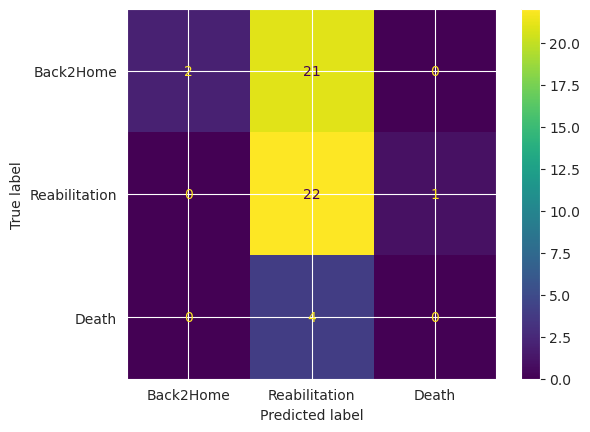

In [163]:
matrix = confusion_matrix(y_test, y_pred)
#matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()

In [164]:
print(classification_report(y_test, y_pred, target_names=["Back2Home", "Reabilitation", "Death"]))
#print(classification_report(y_train, y_pred, target_names=["Back2Home", "Reabilitation", "Death"]))

               precision    recall  f1-score   support

    Back2Home       1.00      0.09      0.16        23
Reabilitation       0.47      0.96      0.63        23
        Death       0.00      0.00      0.00         4

     accuracy                           0.48        50
    macro avg       0.49      0.35      0.26        50
 weighted avg       0.68      0.48      0.36        50



In [165]:
print("AUC ROC:", round(roc_auc_score(y_test, y_score, multi_class='ovr'), 2))

AUC ROC: 0.45


In [122]:
model = result.model

entity_embedding_tensor = model.entity_representations[0](indices=None).cpu()
relation_embedding_tensor = model.relation_representations[0](indices=None).cpu()

In [83]:
colors = [['g', 'r', 'b'][i] for i in y_train]
labels = [i for i in y_train]
#patients_names = [f"P{i}" for i in range(size_train)]
patients_names = [f"<http://nvasc.org/synth_patient_{i}>" for i in range(size_train)]
train_pos = entity_embedding_tensor[tf.entities_to_ids(patients_names)]
train_pos = train_pos.detach().numpy()

In [84]:
out_colors = ['g', 'r', 'b']
#outcomes_names = ["Back2Home", "Reabilitation", "Death"]
outcomes_names = ["<http://nvasc.org/outcome_0.0>", "<http://nvasc.org/outcome_1.0>", "<http://nvasc.org/outcome_2.0>"]
out_pos = entity_embedding_tensor[tf.entities_to_ids(outcomes_names)]
out_pos = out_pos.detach().numpy()

In [85]:
pca = PCA(n_components=2)
train_pos = pca.fit_transform(train_pos)
out_pos = pca.transform(out_pos)

In [86]:
print(f"{round(sum(pca.explained_variance_), 2)}% variance explained")

20.99% variance explained


In [87]:
#relation_names = ["hasOutput", "output"]
relation_names = ["<http://nvasc.org/hasOutcome>"]
rel_pos = relation_embedding_tensor[tf.relations_to_ids(relation_names)]
rel_pos = rel_pos.detach().numpy()
origin = np.array([[0] * 2, [0] * 2])

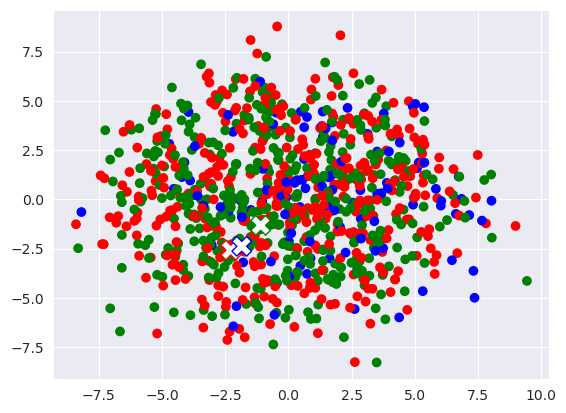

In [88]:
plt.scatter(train_pos[:,0], train_pos[:,1], c=colors)
plt.scatter(out_pos[:,0], out_pos[:,1], s=200, marker='X', edgecolors=out_colors, facecolors=['w'] * len(out_colors))
plt.quiver(*origin, rel_pos[:,0], rel_pos[:,1], scale=8, color=['b', 'r'])
plt.show()

In [89]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(50, 3)

In [90]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.56


In [91]:
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.56


In [92]:
class_weights = [0.443396, 0.432075, 0.124529]

# Compute ROC curve and ROC area for each class with sample weights
for i in range(n_classes):
    sample_weight = np.ones(y_onehot_test.shape[0]) * class_weights[i]
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i], sample_weight=sample_weight)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Interpolation grid
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
weighted_mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    interp_tpr = np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    weighted_mean_tpr += class_weights[i] * interp_tpr

# Compute AUC for the weighted macro-average
fpr["weighted_macro"] = fpr_grid
tpr["weighted_macro"] = weighted_mean_tpr
roc_auc["weighted_macro"] = auc(fpr["weighted_macro"], tpr["weighted_macro"])

print(f"Weighted Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['weighted_macro']:.2f}")


Weighted Macro-averaged One-vs-Rest ROC AUC score:
0.56


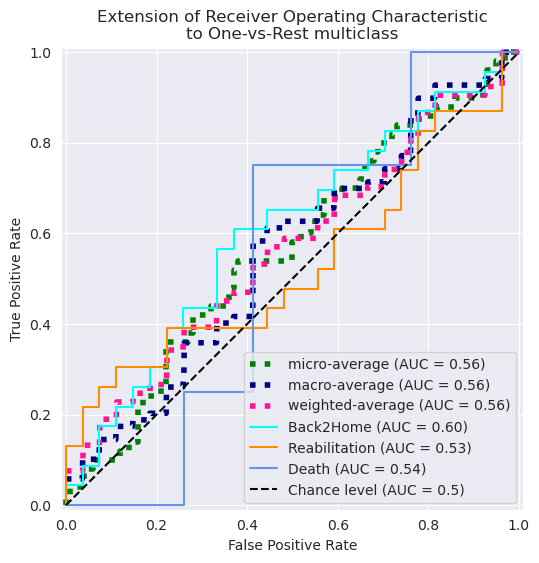

In [93]:
fig, ax = plt.subplots(figsize=(6, 6))

target_names = ["Back2Home", "Reabilitation", "Death"]

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
    color="green",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["weighted_macro"],
    tpr["weighted_macro"],
    label=f"weighted-average (AUC = {roc_auc['weighted_macro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

#ax.grid(False)
#ax.set_facecolor('white')

plt.savefig("test.png")

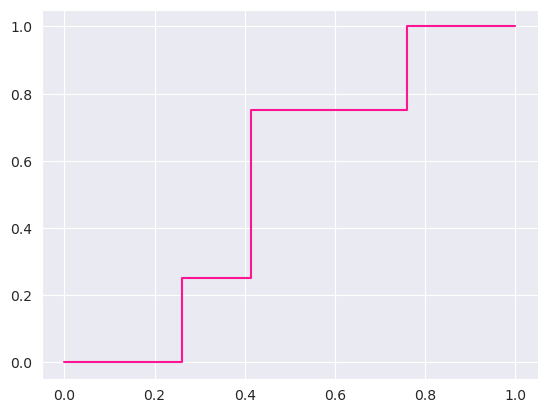

In [94]:
plt.plot(
    fpr[2],
    tpr[2],
    label=f"weighted-average (AUC = {roc_auc['weighted_macro']:.2f})",
    color="deeppink",
)